--- Loading Real Datasets ---
--- Sample Matching ---
Initial samples - Gene: 265, Meth: 269, CNV: 248, Labels: 205
Common samples found: 205
Matched samples - Gene: 205, Meth: 205, CNV: 205, Labels: 205
Sample matching complete!

Dataset loaded: 205 samples
Dimensions - RNA: 44750, Meth: 419546, CNV: 56751
Number of classes: 4
Using batch size: 205 (full-batch training)
Training model with 4 classes

--- Starting Enhanced Bio-Alignment Pipeline ---
Model parameters: 267,893,892
Latent dimension: 128
Initial learning rate: 0.001

Epoch 10 | LR: 0.000934 | Scale: 10.02 | Clf: 0.8351 | Align: 3.6450
Epoch 20 | LR: 0.000753 | Scale: 10.05 | Clf: 0.8234 | Align: 5.5131
Epoch 30 | LR: 0.000505 | Scale: 10.09 | Clf: 0.7044 | Align: 1.1853
Epoch 40 | LR: 0.000258 | Scale: 10.13 | Clf: 0.7904 | Align: 5.2463
Epoch 50 | LR: 0.000076 | Scale: 10.15 | Clf: 0.6300 | Align: 5.5046
Epoch 60 | LR: 0.000010 | Scale: 10.15 | Clf: 0.5464 | Align: 0.3407
Epoch 70 | LR: 0.000076 | Scale: 10.16 | Clf: 0.52

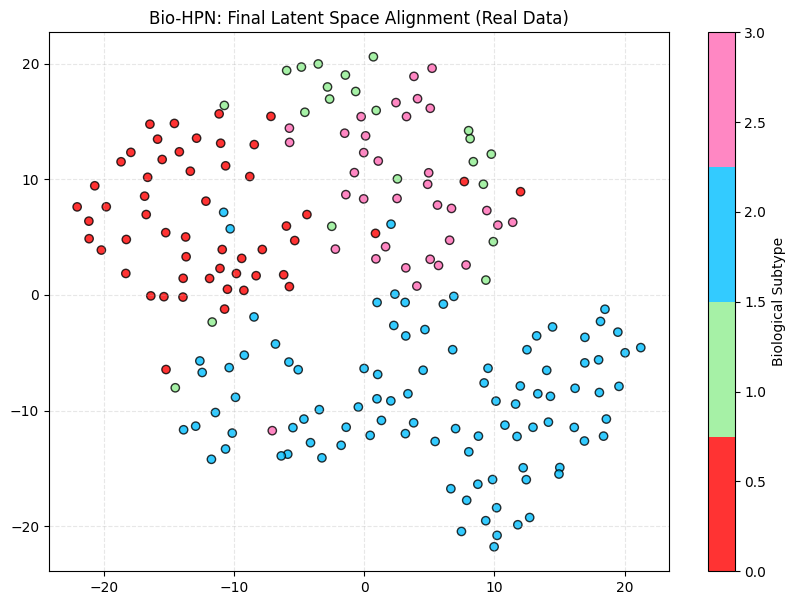

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import ListedColormap

# Suppress administrative warnings for cleaner architect output
warnings.filterwarnings("ignore")

# ==========================================
# 1. DATASET: REAL BIOLOGICAL DATA
# ==========================================
class RealBioDataset(Dataset):
    def __init__(self, gene_df, meth_df, cnv_df, labels_df):
        """
        Initialize dataset with real omics data
        Args:
            gene_df: Gene expression dataframe (samples x features)
            meth_df: Methylation dataframe (samples x features)
            cnv_df: CNV dataframe (samples x features)
            labels_df: Labels dataframe (samples x 1)
        """
        self.gene_data = torch.FloatTensor(gene_df.values)
        self.meth_data = torch.FloatTensor(meth_df.values)
        self.cnv_data = torch.FloatTensor(cnv_df.values)
        self.labels = torch.LongTensor(labels_df.values.flatten())
        
        self.n_samples = len(self.labels)
        self.dims = {
            'rna': self.gene_data.shape[1],
            'meth': self.meth_data.shape[1],
            'cnv': self.cnv_data.shape[1]
        }
        
        print(f"Dataset loaded: {self.n_samples} samples")
        print(f"Dimensions - RNA: {self.dims['rna']}, Meth: {self.dims['meth']}, CNV: {self.dims['cnv']}")
        print(f"Number of classes: {len(torch.unique(self.labels))}")

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        return self.gene_data[idx], self.meth_data[idx], self.cnv_data[idx], self.labels[idx]

# ==========================================
# 2. SAMPLE MATCHING FUNCTION
# ==========================================
def match_samples(gene_df, meth_df, cnv_df, phenotype_df, labels_df):
    """
    Match samples across all omics datasets and labels
    Returns matched dataframes with common samples
    """
    print("--- Sample Matching ---")
    print(f"Initial samples - Gene: {len(gene_df)}, Meth: {len(meth_df)}, CNV: {len(cnv_df)}, Labels: {len(labels_df)}")
    
    # Find common samples across all datasets
    common_samples = set(gene_df.index) & set(meth_df.index) & set(cnv_df.index) & set(labels_df.index)
    common_samples = sorted(list(common_samples))
    
    print(f"Common samples found: {len(common_samples)}")
    
    if len(common_samples) == 0:
        raise ValueError("No common samples found across all datasets!")
    
    # Match all dataframes to common samples
    gene_matched = gene_df.loc[common_samples]
    meth_matched = meth_df.loc[common_samples]
    cnv_matched = cnv_df.loc[common_samples]
    labels_matched = labels_df.loc[common_samples]
    
    print(f"Matched samples - Gene: {len(gene_matched)}, Meth: {len(meth_matched)}, CNV: {len(cnv_matched)}, Labels: {len(labels_matched)}")
    print("Sample matching complete!\n")
    
    return gene_matched, meth_matched, cnv_matched, labels_matched

# ==========================================
# 3. ARCHITECTURE: RESIDUAL BIO-ENCODER (Optimized for High-Dimensional Data)
# ==========================================
class BioEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=128):
        """
        Encoder optimized for high-dimensional omics data (44K-419K features)
        Architecture: input_dim → 512 → 256 → latent_dim
        """
        super(BioEncoder, self).__init__()
        # First projection: high-dim → 512 (gradual reduction)
        self.initial_proj = nn.Linear(input_dim, 512)
        self.initial_bn = nn.BatchNorm1d(512)
        self.initial_dropout = nn.Dropout(0.3)
        
        # Residual block: 512 → 256
        self.residual_block = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2)
        )
        
        # Projection to match residual dimensions
        self.skip_proj = nn.Linear(512, 256)
        
        # Final projection: 256 → latent_dim
        self.final_proj = nn.Linear(256, latent_dim)
        self.layer_norm = nn.LayerNorm(latent_dim)

    def forward(self, x):
        # Initial projection with dropout
        x = self.initial_proj(x)
        x = self.initial_bn(x)
        x = F.leaky_relu(x, 0.2)
        x = self.initial_dropout(x)
        
        # Residual connection
        identity = self.skip_proj(x)
        x = self.residual_block(x)
        x = x + identity  # Residual connection
        
        # Final projection
        x = self.final_proj(x)
        return self.layer_norm(x)

class BioHPN(nn.Module):
    def __init__(self, dims_dict, num_classes, latent_dim=128):
        """
        Hybrid Prototype Network optimized for high-dimensional multi-omics data
        """
        super(BioHPN, self).__init__()
        self.rna_enc = BioEncoder(dims_dict['rna'], latent_dim)
        self.meth_enc = BioEncoder(dims_dict['meth'], latent_dim)
        self.cnv_enc = BioEncoder(dims_dict['cnv'], latent_dim)

        # Learnable prototypes for each class
        self.prototypes = nn.Parameter(torch.randn(num_classes, latent_dim))
        
        # Attention-based gating mechanism
        self.gate = nn.Sequential(
            nn.Linear(latent_dim * 3, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 3),
            nn.Softmax(dim=1)  # Changed to Softmax for proper attention weights
        )

        # Learnable scaling for classification sharpness
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(10))

    def forward(self, rna, meth, cnv):
        z_rna = F.normalize(self.rna_enc(rna), p=2, dim=1)
        z_meth = F.normalize(self.meth_enc(meth), p=2, dim=1)
        z_cnv = F.normalize(self.cnv_enc(cnv), p=2, dim=1)

        combined = torch.cat([z_rna, z_meth, z_cnv], dim=1)
        weights = self.gate(combined)  # Now sums to 1 (softmax)

        fused = (z_rna * weights[:, 0].unsqueeze(1) +
                 z_meth * weights[:, 1].unsqueeze(1) +
                 z_cnv * weights[:, 2].unsqueeze(1))

        fused_norm = F.normalize(fused, p=2, dim=1)
        proto_norm = F.normalize(self.prototypes, p=2, dim=1)

        # Apply learnable scaling
        scale = self.logit_scale.exp()
        logits = torch.mm(fused_norm, proto_norm.t()) * scale
        return logits, fused_norm, (z_rna, z_meth, z_cnv)

# ==========================================
# 4. LOSS FUNCTIONS
# ==========================================
def contrastive_alignment_loss(z_views, temperature=0.05):
    """
    Multi-view contrastive alignment loss
    Lower temperature (0.05) creates harder negatives for better alignment
    """
    loss = 0
    pairs = [(0, 1), (1, 2), (0, 2)]  # RNA-Meth, Meth-CNV, RNA-CNV
    for i, j in pairs:
        z1, z2 = z_views[i], z_views[j]
        sim_matrix = torch.mm(z1, z2.t()) / temperature
        labels = torch.arange(z1.size(0)).to(z1.device)
        loss += F.cross_entropy(sim_matrix, labels)
    return loss / len(pairs)

# ==========================================
# 5. TRAINING ENGINE
# ==========================================
def run_architect_pipeline():
    # Load real datasets
    print("--- Loading Real Datasets ---")
    gene_df = pd.read_csv("../NewDatasets/processed_expression_4O.csv", index_col=0).T
    meth_df = pd.read_csv("../NewDatasets/processed_methylation_4O.csv", index_col=0).T
    cnv_df = pd.read_csv("../NewDatasets/processed_cnv_4O.csv", index_col=0).T
    phenotype_df = pd.read_csv("../NewDatasets/phenotype_data_clean_FXS_MOFA_3Omics.csv", index_col=0)
    labels_df = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)
    
    # Match samples across all datasets
    gene_matched, meth_matched, cnv_matched, labels_matched = match_samples(
        gene_df, meth_df, cnv_df, phenotype_df, labels_df
    )
    
    # Create dataset with matched samples
    dataset = RealBioDataset(gene_matched, meth_matched, cnv_matched, labels_matched)
    
    # Use full-batch training for small datasets (better for contrastive learning and BatchNorm)
    # For small multi-omics datasets, full-batch training provides:
    # 1. More stable gradients
    # 2. Better BatchNorm statistics
    # 3. Stronger contrastive alignment (more negative pairs)
    batch_size = len(dataset) if len(dataset) < 500 else 64
    print(f"Using batch size: {batch_size} ({'full-batch' if batch_size == len(dataset) else 'mini-batch'} training)")
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Get number of unique classes
    num_classes = len(torch.unique(dataset.labels))
    print(f"Training model with {num_classes} classes\n")
    
    # Initialize model with optimized latent dimension
    model = BioHPN(dataset.dims, num_classes=num_classes, latent_dim=128)
    
    # Optimized optimizer settings for high-dimensional data
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    
    # Learning rate scheduler for better convergence
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-5)

    print("--- Starting Enhanced Bio-Alignment Pipeline ---")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Latent dimension: 128")
    print(f"Initial learning rate: 0.001\n")

    for epoch in range(1, 81):  # Increased epochs for better convergence
        model.train()
        t_clf, t_aln = 0, 0

        # Dynamic loss weighting (focus on alignment early, classification later)
        align_weight = 3.0 if epoch < 40 else 1.5
        clf_weight = 0.3 if epoch < 40 else 1.5

        for rna, meth, cnv, labels in train_loader:
            optimizer.zero_grad()

            # Modality dropout for robustness (reduced probability for better learning)
            if epoch < 60:
                drop = np.random.choice(['none', 'rna', 'meth', 'cnv'], p=[0.601, 0.133, 0.133, 0.133])
                if drop == 'rna': rna = torch.zeros_like(rna)
                elif drop == 'meth': meth = torch.zeros_like(meth)
                elif drop == 'cnv': cnv = torch.zeros_like(cnv)

            logits, fused, views = model(rna, meth, cnv)
            clf_loss = F.cross_entropy(logits, labels, label_smoothing=0.1)  # Reduced label smoothing
            align_loss = contrastive_alignment_loss(views, temperature=0.05)  # Lower temperature for harder negatives

            loss = (clf_weight * clf_loss) + (align_weight * align_loss)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Tighter gradient clipping
            optimizer.step()

            t_clf += clf_loss.item(); t_aln += align_loss.item()
        
        # Step the scheduler
        scheduler.step()

        if epoch % 10 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch:02d} | LR: {current_lr:.6f} | Scale: {model.logit_scale.exp().item():.2f} | "
                  f"Clf: {t_clf/len(train_loader):.4f} | Align: {t_aln/len(train_loader):.4f}")

    return model, train_loader

def visualize_results(model, loader):
    model.eval()
    all_z, all_y = [], []
    with torch.no_grad():
        for rna, meth, cnv, y in loader:
            _, z_norm, _ = model(rna, meth, cnv)
            all_z.append(z_norm.numpy())
            all_y.append(y.numpy())
    
    z_embed = np.concatenate(all_z)
    y_true = np.concatenate(all_y)
    tsne = TSNE(n_components=2, perplexity=20, init='pca', random_state=42)
    z_2d = tsne.fit_transform(z_embed)
    
    # Define custom colors: red, light green, bright blue, pink
    custom_cmap = ListedColormap(["red", "lightgreen", "deepskyblue", "hotpink"])
    
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        z_2d[:, 0], z_2d[:, 1], c=y_true, cmap=custom_cmap, alpha=0.8, edgecolors='k'
    )
    plt.colorbar(scatter, label='Biological Subtype')
    plt.title("Bio-HPN: Final Latent Space Alignment (Real Data)")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

if __name__ == "__main__":
    trained_model, data_loader = run_architect_pipeline()
    visualize_results(trained_model, data_loader)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings

# Suppress administrative warnings for cleaner architect output
warnings.filterwarnings("ignore")

# ==========================================
# 1. DATASET: REAL BIOLOGICAL DATA
# ==========================================
class RealBioDataset(Dataset):
    def __init__(self, gene_df, meth_df, cnv_df, labels_df):
        """
        Initialize dataset with real omics data
        Args:
            gene_df: Gene expression dataframe (samples x features)
            meth_df: Methylation dataframe (samples x features)
            cnv_df: CNV dataframe (samples x features)
            labels_df: Labels dataframe (samples x 1)
        """
        self.gene_data = torch.FloatTensor(gene_df.values)
        self.meth_data = torch.FloatTensor(meth_df.values)
        self.cnv_data = torch.FloatTensor(cnv_df.values)
        self.labels = torch.LongTensor(labels_df.values.flatten())
        
        self.n_samples = len(self.labels)
        self.dims = {
            'rna': self.gene_data.shape[1],
            'meth': self.meth_data.shape[1],
            'cnv': self.cnv_data.shape[1]
        }
        
        print(f"Dataset loaded: {self.n_samples} samples")
        print(f"Dimensions - RNA: {self.dims['rna']}, Meth: {self.dims['meth']}, CNV: {self.dims['cnv']}")
        print(f"Number of classes: {len(torch.unique(self.labels))}")

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        return self.gene_data[idx], self.meth_data[idx], self.cnv_data[idx], self.labels[idx]

# ==========================================
# 2. SAMPLE MATCHING FUNCTION
# ==========================================
def match_samples(gene_df, meth_df, cnv_df, phenotype_df, labels_df):
    """
    Match samples across all omics datasets and labels
    Returns matched dataframes with common samples
    """
    print("--- Sample Matching ---")
    print(f"Initial samples - Gene: {len(gene_df)}, Meth: {len(meth_df)}, CNV: {len(cnv_df)}, Labels: {len(labels_df)}")
    
    # Find common samples across all datasets
    common_samples = set(gene_df.index) & set(meth_df.index) & set(cnv_df.index) & set(labels_df.index)
    common_samples = sorted(list(common_samples))
    
    print(f"Common samples found: {len(common_samples)}")
    
    if len(common_samples) == 0:
        raise ValueError("No common samples found across all datasets!")
    
    # Match all dataframes to common samples
    gene_matched = gene_df.loc[common_samples]
    meth_matched = meth_df.loc[common_samples]
    cnv_matched = cnv_df.loc[common_samples]
    labels_matched = labels_df.loc[common_samples]
    
    print(f"Matched samples - Gene: {len(gene_matched)}, Meth: {len(meth_matched)}, CNV: {len(cnv_matched)}, Labels: {len(labels_matched)}")
    print("Sample matching complete!\n")
    
    return gene_matched, meth_matched, cnv_matched, labels_matched

# ==========================================
# 3. ARCHITECTURE: RESIDUAL BIO-ENCODER (Optimized for High-Dimensional Data)
# ==========================================
class BioEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=128):
        """
        Encoder optimized for high-dimensional omics data (44K-419K features)
        Architecture: input_dim → 512 → 256 → latent_dim
        """
        super(BioEncoder, self).__init__()
        # First projection: high-dim → 512 (gradual reduction)
        self.initial_proj = nn.Linear(input_dim, 512)
        self.initial_bn = nn.BatchNorm1d(512)
        self.initial_dropout = nn.Dropout(0.3)
        
        # Residual block: 512 → 256
        self.residual_block = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2)
        )
        
        # Projection to match residual dimensions
        self.skip_proj = nn.Linear(512, 256)
        
        # Final projection: 256 → latent_dim
        self.final_proj = nn.Linear(256, latent_dim)
        self.layer_norm = nn.LayerNorm(latent_dim)

    def forward(self, x):
        # Initial projection with dropout
        x = self.initial_proj(x)
        x = self.initial_bn(x)
        x = F.leaky_relu(x, 0.2)
        x = self.initial_dropout(x)
        
        # Residual connection
        identity = self.skip_proj(x)
        x = self.residual_block(x)
        x = x + identity  # Residual connection
        
        # Final projection
        x = self.final_proj(x)
        return self.layer_norm(x)

class BioHPN(nn.Module):
    def __init__(self, dims_dict, num_classes, latent_dim=128):
        """
        Hybrid Prototype Network optimized for high-dimensional multi-omics data
        """
        super(BioHPN, self).__init__()
        self.rna_enc = BioEncoder(dims_dict['rna'], latent_dim)
        self.meth_enc = BioEncoder(dims_dict['meth'], latent_dim)
        self.cnv_enc = BioEncoder(dims_dict['cnv'], latent_dim)

        # Learnable prototypes for each class
        self.prototypes = nn.Parameter(torch.randn(num_classes, latent_dim))
        
        # Attention-based gating mechanism
        self.gate = nn.Sequential(
            nn.Linear(latent_dim * 3, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 3),
            nn.Softmax(dim=1)  # Changed to Softmax for proper attention weights
        )

        # Learnable scaling for classification sharpness
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(10))

    def forward(self, rna, meth, cnv):
        z_rna = F.normalize(self.rna_enc(rna), p=2, dim=1)
        z_meth = F.normalize(self.meth_enc(meth), p=2, dim=1)
        z_cnv = F.normalize(self.cnv_enc(cnv), p=2, dim=1)

        combined = torch.cat([z_rna, z_meth, z_cnv], dim=1)
        weights = self.gate(combined)  # Now sums to 1 (softmax)

        fused = (z_rna * weights[:, 0].unsqueeze(1) +
                 z_meth * weights[:, 1].unsqueeze(1) +
                 z_cnv * weights[:, 2].unsqueeze(1))

        fused_norm = F.normalize(fused, p=2, dim=1)
        proto_norm = F.normalize(self.prototypes, p=2, dim=1)

        # Apply learnable scaling
        scale = self.logit_scale.exp()
        logits = torch.mm(fused_norm, proto_norm.t()) * scale
        return logits, fused_norm, (z_rna, z_meth, z_cnv)

# ==========================================
# 4. LOSS FUNCTIONS
# ==========================================
def contrastive_alignment_loss(z_views, temperature=0.05):
    """
    Multi-view contrastive alignment loss
    Lower temperature (0.05) creates harder negatives for better alignment
    """
    loss = 0
    pairs = [(0, 1), (1, 2), (0, 2)]  # RNA-Meth, Meth-CNV, RNA-CNV
    for i, j in pairs:
        z1, z2 = z_views[i], z_views[j]
        sim_matrix = torch.mm(z1, z2.t()) / temperature
        labels = torch.arange(z1.size(0)).to(z1.device)
        loss += F.cross_entropy(sim_matrix, labels)
    return loss / len(pairs)

# ==========================================
# 5. EARLY STOPPING CLASS
# ==========================================
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0001, verbose=True):
        """
        Early stopping to prevent overfitting
        Args:
            patience: Number of epochs to wait before stopping
            min_delta: Minimum change to qualify as improvement
            verbose: Print messages
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict().copy()
            if self.verbose:
                print(f"Initial validation loss: {val_loss:.4f}")
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping triggered! Best loss: {self.best_loss:.4f}")
        else:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict().copy()
            self.counter = 0
            if self.verbose:
                print(f"Validation loss improved to {val_loss:.4f}")



In [7]:
def run_architect_pipeline():
    # Check CUDA availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n{'='*60}")
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"{'='*60}\n")
    
    # Load real datasets
    print("--- Loading Real Datasets ---")
    gene_df = pd.read_csv("../NewDatasets/processed_expression_4O.csv", index_col=0).T
    meth_df = pd.read_csv("../NewDatasets/processed_methylation_4O.csv", index_col=0).T
    cnv_df = pd.read_csv("../NewDatasets/processed_cnv_4O.csv", index_col=0).T
    phenotype_df = pd.read_csv("../NewDatasets/phenotype_data_clean_FXS_MOFA_3Omics.csv", index_col=0)
    labels_df = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)
    
    # Match samples across all datasets
    gene_matched, meth_matched, cnv_matched, labels_matched = match_samples(
        gene_df, meth_df, cnv_df, phenotype_df, labels_df
    )
    
    # Create dataset with matched samples
    dataset = RealBioDataset(gene_matched, meth_matched, cnv_matched, labels_matched)
    
    # Split into train/validation (80/20) for early stopping
    from sklearn.model_selection import train_test_split
    indices = list(range(len(dataset)))
    train_indices, val_indices = train_test_split(
        indices, test_size=0.2, random_state=42, stratify=dataset.labels.numpy()
    )
    
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    
    print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
    
    # Use full-batch training for small datasets
    batch_size = len(train_dataset) if len(train_dataset) < 500 else 64
    val_batch_size = len(val_dataset)
    print(f"Using batch size - Train: {batch_size}, Val: {val_batch_size}\n")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

    # Get number of unique classes
    num_classes = len(torch.unique(dataset.labels))
    print(f"Training model with {num_classes} classes\n")
    
    # Initialize model with optimized latent dimension
    model = BioHPN(dataset.dims, num_classes=num_classes, latent_dim=128)
    model = model.to(device)  # Move model to GPU
    
    # Optimized optimizer settings for high-dimensional data
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    
    # Learning rate scheduler for better convergence
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=1e-5)
    
    # Early stopping with patience=10
    early_stopping = EarlyStopping(patience=10, min_delta=0.0001, verbose=True)

    print("--- Starting Enhanced Bio-Alignment Pipeline ---")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Latent dimension: 128")
    print(f"Initial learning rate: 0.001")
    print(f"Early stopping patience: 10\n")

    for epoch in range(1, 201):  # Max epochs (early stopping will stop earlier)
        # ===== TRAINING =====
        model.train()
        t_clf, t_aln = 0, 0

        # Dynamic loss weighting (focus on alignment early, classification later)
        align_weight = 3.0 if epoch < 40 else 1.5
        clf_weight = 0.3 if epoch < 40 else 1.5

        for rna, meth, cnv, labels in train_loader:
            # Move data to GPU
            rna, meth, cnv, labels = rna.to(device), meth.to(device), cnv.to(device), labels.to(device)
            
            optimizer.zero_grad()

            # Modality dropout for robustness (reduced probability for better learning)
            if epoch < 60:
                drop = np.random.choice(['none', 'rna', 'meth', 'cnv'], p=[0.601, 0.133, 0.133, 0.133])
                if drop == 'rna': rna = torch.zeros_like(rna)
                elif drop == 'meth': meth = torch.zeros_like(meth)
                elif drop == 'cnv': cnv = torch.zeros_like(cnv)

            logits, fused, views = model(rna, meth, cnv)
            clf_loss = F.cross_entropy(logits, labels, label_smoothing=0.1)
            align_loss = contrastive_alignment_loss(views, temperature=0.05)

            loss = (clf_weight * clf_loss) + (align_weight * align_loss)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

            t_clf += clf_loss.item(); t_aln += align_loss.item()
        
        # ===== VALIDATION =====
        model.eval()
        val_clf, val_aln = 0, 0
        with torch.no_grad():
            for rna, meth, cnv, labels in val_loader:
                # Move data to GPU
                rna, meth, cnv, labels = rna.to(device), meth.to(device), cnv.to(device), labels.to(device)
                
                logits, fused, views = model(rna, meth, cnv)
                clf_loss = F.cross_entropy(logits, labels)
                align_loss = contrastive_alignment_loss(views, temperature=0.05)
                
                val_loss = (clf_weight * clf_loss) + (align_weight * align_loss)
                val_clf += clf_loss.item()
                val_aln += align_loss.item()
        
        val_total_loss = val_clf + val_aln
        
        # Step the scheduler
        scheduler.step()
        
        # Print progress
        if epoch % 5 == 0 or epoch == 1:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch:03d} | LR: {current_lr:.6f} | Scale: {model.logit_scale.exp().item():.2f}")
            print(f"  Train - Clf: {t_clf/len(train_loader):.4f} | Align: {t_aln/len(train_loader):.4f}")
            print(f"  Val   - Clf: {val_clf/len(val_loader):.4f} | Align: {val_aln/len(val_loader):.4f} | Total: {val_total_loss:.4f}")
        
        # Early stopping check
        early_stopping(val_total_loss, model)
        if early_stopping.early_stop:
            print(f"\nTraining stopped at epoch {epoch}")
            # Load best model
            model.load_state_dict(early_stopping.best_model_state)
            break
    
    print(f"\nTraining completed! Best validation loss: {early_stopping.best_loss:.4f}")
    return model, train_loader, val_loader, device



Using device: cuda
GPU: NVIDIA GeForce RTX 3060
GPU Memory: 12.88 GB

--- Loading Real Datasets ---
--- Sample Matching ---
Initial samples - Gene: 265, Meth: 269, CNV: 248, Labels: 205
Common samples found: 205
Matched samples - Gene: 205, Meth: 205, CNV: 205, Labels: 205
Sample matching complete!

Dataset loaded: 205 samples
Dimensions - RNA: 44750, Meth: 419546, CNV: 56751
Number of classes: 4
Train samples: 164, Validation samples: 41
Using batch size - Train: 164, Val: 41

Training model with 4 classes

--- Starting Enhanced Bio-Alignment Pipeline ---
Model parameters: 267,893,892
Latent dimension: 128
Initial learning rate: 0.001
Early stopping patience: 10

Epoch 001 | LR: 0.001000 | Scale: 9.99
  Train - Clf: 1.7514 | Align: 6.4216
  Val   - Clf: 1.1094 | Align: 4.3249 | Total: 5.4343
Initial validation loss: 5.4343
EarlyStopping counter: 1/10
EarlyStopping counter: 2/10
EarlyStopping counter: 3/10
Epoch 005 | LR: 0.000990 | Scale: 9.98
  Train - Clf: 1.0167 | Align: 4.2056
  

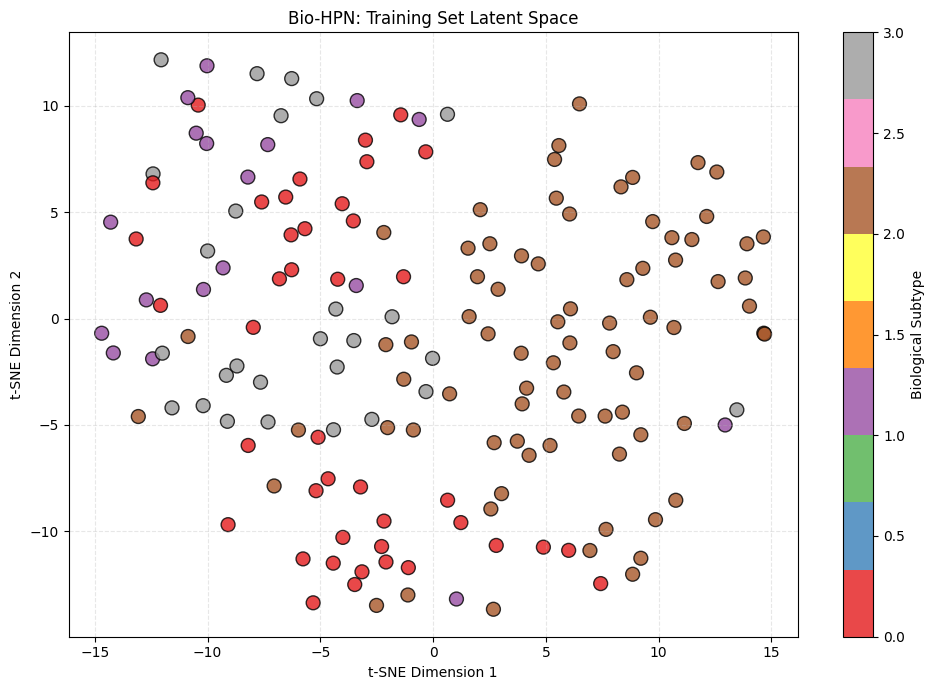


Visualizing Validation Data:


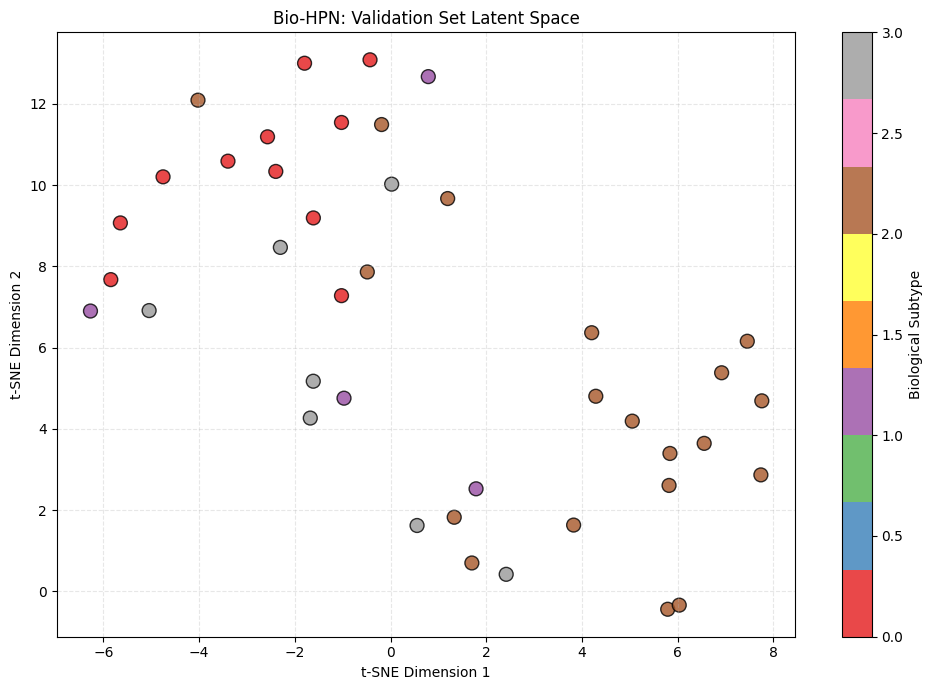

In [8]:
# ==========================================
# 6. TRAINING ENGINE
# ==========================================

def visualize_results(model, loader, device, title="Bio-HPN: Latent Space"):
    model.eval()
    all_z, all_y = [], []
    with torch.no_grad():
        for rna, meth, cnv, y in loader:
            # Move to GPU
            rna, meth, cnv = rna.to(device), meth.to(device), cnv.to(device)
            _, z_norm, _ = model(rna, meth, cnv)
            # Move back to CPU for visualization
            all_z.append(z_norm.cpu().numpy())
            all_y.append(y.numpy())

    z_embed = np.concatenate(all_z)
    y_true = np.concatenate(all_y)
    
    # Adjust perplexity based on sample size
    perplexity = min(20, len(z_embed) // 3)
    tsne = TSNE(n_components=2, perplexity=perplexity, init='pca', random_state=42)
    z_2d = tsne.fit_transform(z_embed)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_true, cmap='Set1', alpha=0.8, edgecolors='k', s=100)
    plt.colorbar(scatter, label='Biological Subtype')
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    trained_model, train_loader, val_loader, device = run_architect_pipeline()
    print("\nVisualizing Training Data:")
    visualize_results(trained_model, train_loader, device, "Bio-HPN: Training Set Latent Space")
    print("\nVisualizing Validation Data:")
    visualize_results(trained_model, val_loader, device, "Bio-HPN: Validation Set Latent Space")